In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
import itertools
import random
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
sample_train = pd.read_csv('data/CBT_CN_train.csv',delimiter=';')
sample_train = sample_train.sample(n=10000, replace=True)
sample_valid = pd.read_csv('data/CBT_CN_valid.csv',delimiter=';')

In [3]:
sample_train['Document'] = sample_train['Document'].apply(literal_eval)
sample_valid['Document'] = sample_valid['Document'].apply(literal_eval)
sample_train['Query'] = sample_train['Query'].apply(literal_eval)
sample_valid['Query'] = sample_valid['Query'].apply(literal_eval)
sample_train['Candidates'] = sample_train['Candidates'].apply(literal_eval)
sample_valid['Candidates'] = sample_valid['Candidates'].apply(literal_eval)

In [4]:
def categorize_text(text, word_to_id, mapped_words):
    newtext = []
    text_to_process = text
    if type(text) is not list:
        text_to_process = [text]
    for word in text_to_process:
        if mapped_words is None or word in mapped_words:
            newtext.append(word_to_id[word])
        else:
            newtext.append(word_to_id['<NA>'])
    return newtext

def categorize_df(df, word_to_id=None):
    cat_df = pd.DataFrame(dtype=str).reindex_like(df)
    cat_df['Document'] = [[]] * len(df)
    cat_df['Query'] = [[]] * len(df)
    cat_df['Candidates'] = [[]] * len(df)
    cat_df['Answer'] = ['<NA>'] * len(df)
    words = []
    mapped_words = None
    id_to_word = None
    if word_to_id is None:
        print('Processing train data...')
        words += list(itertools.chain.from_iterable(df['Document'].values))
        words += list(itertools.chain.from_iterable(df['Query'].values))
        words += list(itertools.chain.from_iterable(df['Candidates'].values))
        words += list(df['Answer'].values)
        print('\t random word:', words[19374])
        words += ['<NA>']
        words = set(words)
        print('\t dictionary size(with NA):', len(words))
        word_to_id = {t: i for i, t in enumerate(words)}
        id_to_word = {i: t for i, t in enumerate(words)}
    else:
        print('Processing test data...')
        mapped_words = set(word_to_id.keys())
    
    cat_df['Document'] = df['Document'].apply(lambda row: categorize_text(row, word_to_id, mapped_words))
    cat_df['Query'] = df['Query'].apply(lambda row: categorize_text(row, word_to_id, mapped_words))
    cat_df['Candidates'] = df['Candidates'].apply(lambda row: categorize_text(row, word_to_id, mapped_words))
    cat_df['Answer'] = df['Answer'].apply(lambda row: categorize_text(row, word_to_id, mapped_words)[0])
    
    return cat_df, len(words), word_to_id, id_to_word

In [5]:
def check_categorization(id_to_word, df, cat_df, isTrain=True):
    print('Checking categorization...')
    ind_s = np.random.randint(0, high=len(df), size=100)
    allClear = True
    NA_freq = 0
    tot_len = 0
    for i in ind_s:
        for col in df.columns[:-1]:
            temp = cat_df[col].iloc[i]
            assert type(temp) is list
            tot_len += len(temp)
            for j in range(len(temp)):
                if id_to_word[temp[j]] != df[col].iloc[i][j]:
                    if isTrain or id_to_word[temp[j]] != '<NA>':
                        allClear = False
                    else:
                        NA_freq += 1
        tot_len += 1
        if id_to_word[cat_df['Answer'].iloc[i]] != df['Answer'].iloc[i]:
            if isTrain or id_to_word[cat_df['Answer'].iloc[i]] != '<NA>':
                allClear = False
            else:
                NA_freq += 1
    NA_freq = 100.0 * float(NA_freq) / float(tot_len)
    if allClear:
        print('\t Sector is clear')
        if NA_freq > 0:
            print('\t Percentage of <NA> words:', NA_freq)
    else:
        print('\t ... Not clear! Not clear!')

In [6]:
cat_train, dictionary_size, word_to_id, id_to_word = categorize_df(sample_train)
check_categorization(id_to_word, sample_train, cat_train)

Processing train data...
	 random word: of
	 dictionary size(with NA): 33648
Checking categorization...
	 Sector is clear


In [7]:
cat_valid, _, _, _ = categorize_df(sample_valid, word_to_id)
check_categorization(id_to_word, sample_valid, cat_valid, isTrain=False)

Processing test data...
Checking categorization...
	 Sector is clear
	 Percentage of <NA> words: 0.7929182748783353


In [8]:
inds_ex = range(0, 10000)
temp = np.array([len(arr) for arr in cat_train.iloc[inds_ex]['Document'].values])

In [9]:
np.sum(temp < 800)

9776

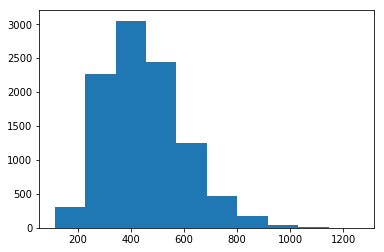

In [10]:
plt.hist(temp)
plt.show()

In [11]:
cat_train.head()

,Document,Query,Candidates,Answer
80118,"[9905, 12051, 24430, 23400, 584, 16078, 12051,...","[23610, 12051, 4752, 27129, 12315, 20829, 1872...","[28163, 30033, 4905, 31316, 2265, 1672, 584, 2...",4905
105129,"[6357, 25317, 33112, 215, 19026, 18970, 2254, ...","[14257, 26964, 23610, 26964, 28320, 13449, 269...","[13449, 12424, 17375, 24830, 798, 2254, 2232, ...",5588
47932,"[23896, 7007, 23400, 23489, 19928, 25933, 2943...","[2943, 21629, 8988, 7007, 11261, 27564, 26964,...","[23489, 8638, 7228, 7676, 32898, 32689, 22788,...",22788
39922,"[9081, 23400, 31054, 26766, 23400, 16788, 1206...","[16485, 12069, 23400, 1368, 21337, 82, 21096, ...","[8326, 16788, 11493, 15389, 259, 7112, 12292, ...",259
13399,"[12176, 10476, 16749, 26964, 11333, 2943, 2500...","[18084, 12069, 30227, 32877, 306, 26964, 6357,...","[30424, 13631, 26437, 21096, 20708, 26679, 278...",19982


In [12]:
inds_x = [1, 2, 3]
for arr in cat_train.iloc[inds_x].values:
    print(arr[2])

[13449, 12424, 17375, 24830, 798, 2254, 2232, 5588, 16978, 20998]
[23489, 8638, 7228, 7676, 32898, 32689, 22788, 1672, 12292, 9795]
[8326, 16788, 11493, 15389, 259, 7112, 12292, 17413, 16883, 1039]


In [57]:
np.array(np.array([1,2,2]) == 2, dtype=int)

array([0, 1, 1])

In [63]:
def sample_batch(data, batch_size, word_to_id, D_max_len=900, Q_max_len=100, offset=None):
    if offset is None:
        inds = random.sample(range(len(data)), batch_size)
    else:
        inds = range(offset, offset + batch_size)
    D_lengths = np.array([min(len(arr), D_max_len) for arr in data.iloc[inds]['Document'].values])
    Q_lengths = np.array([min(len(arr), Q_max_len) for arr in data.iloc[inds]['Query'].values])
    D,Q,C,y = [],[],[],[]
    for arr in data.iloc[inds].values:
        if len(arr[0]) < D_max_len:
            D += [arr[0] + [word_to_id['<NA>']]*(D_max_len - len(arr[0]))]
        else:
            D += [arr[0][0:D_max_len]]
        
        if len(arr[1]) < Q_max_len:
            Q += [arr[1] + [word_to_id['<NA>']]*(Q_max_len - len(arr[1]))]
        else:
            Q += [arr[1][0:Q_max_len]]
        C += [[list(np.array(D[-1]) == val) for val in arr[2]]]
        #C += [arr[2]]
        y += [list(np.array(np.array(arr[2]) == arr[3],dtype=int))]
    D, Q = np.array(D), np.array(Q)
    C,y = np.array(C,dtype=int),np.array(y)
    return D, Q, C, y, D_lengths, Q_lengths

In [88]:
D_ex, Q_ex, C_ex, y_ex, D_l_ex, Q_l_ex = sample_batch(cat_train, 3, word_to_id)

In [91]:
for i in range(10):
    print(np.where(C_ex[0][i] == 1)[0])

[ 27 238 253 293]
[ 99 280]
[135]
[233 248]
[ 77 203]
[213]
[332]
[277]
[291]
[197 210]


In [97]:
C_ex.shape

(3, 10, 900)

In [116]:
tf.reset_default_graph()

A = tf.placeholder(tf.float32, [None, None])
B = tf.placeholder(tf.float32, [None, 3, None])

pos = tf.reduce_sum(tf.multiply(tf.expand_dims(A,axis=1), B), axis=2)
#pos = tf.gather(params=A, indices=B, axis=1)
print(pos.shape)

B_ex = np.array([[[1,0,0,1],[0,1,0,0],[0,0,1,0]],[[0,1,0,0],[0,0,1,0],[1,0,0,1]]])

with tf.Session() as sess:
    pos_ex = sess.run(pos, {A: np.array([[0.1, 0.2, 0.3, 0.4], [0.2, 0.4, 0.4, 0.0]]),
                            B: B_ex})
    print(pos_ex)
    print(pos_ex.shape)

(?, 3)
[[ 0.5         0.2         0.30000001]
 [ 0.40000001  0.40000001  0.2       ]]
(2, 3)


In [128]:
emb_dim = 50
rnn_dim = 50

tf.reset_default_graph()
g = tf.Graph()

with g.as_default():
    D = tf.placeholder(tf.int32, [None, 128], name='Document')
    len_D = tf.placeholder(tf.int32, [None], name='Document_lengths')
    Q = tf.placeholder(tf.int32, [None, 16], name='Query')
    len_Q = tf.placeholder(tf.int32, [None], name='Query_lengths')
    C = tf.placeholder(tf.float32, [None, 10, 128], name='Candidates')
    y = tf.placeholder(tf.int32, [None, 10], name='Answers')

    W_e = tf.Variable(tf.random_uniform([dictionary_size, emb_dim], -0.05, 0.05, 
                                    dtype=tf.float32), name='Embedding_matrix')
    e_D = tf.nn.embedding_lookup(W_e, D, name='Embedded_document')
    e_Q = tf.nn.embedding_lookup(W_e, Q, name='Embedded_query')
    print(e_D.shape, e_Q.shape)
    
    with tf.variable_scope('Document_processor'):
        basic_cell = tf.nn.rnn_cell.GRUCell(rnn_dim, activation=tf.nn.relu)
        h_Doc, _ = tf.nn.dynamic_rnn(basic_cell, e_D, sequence_length=len_D, dtype=tf.float32)
    with tf.variable_scope('Query_processor'):
        basic_cell = tf.nn.rnn_cell.GRUCell(rnn_dim, activation=tf.nn.relu)
        h_Query, _ = tf.nn.dynamic_rnn(basic_cell, e_Q, sequence_length=len_Q, dtype=tf.float32)
    
    print(h_Doc.shape, h_Query.shape)
    M = tf.matmul(h_Doc, h_Query, transpose_b=True, name='Matching_scores')
    print(M.shape)
    
    with tf.variable_scope('Query_to_Doc_Attention'):
        alpha = tf.nn.softmax(M, dim=1, name='Query_to_Document_attention')
    with tf.variable_scope('Doc_to_Query_Attention'):
        beta = tf.reduce_sum(tf.nn.softmax(M, dim=2, name='Document_to_Query_attention'), 
                             axis=1, name='Avg_doc_to_Query_att')
    s = tf.reduce_sum(tf.multiply(alpha, beta), axis=2, name='Final_scores')
    
    with tf.variable_scope('Aggregating_results'):
        logits = tf.reduce_sum(tf.multiply(tf.expand_dims(s,axis=1), C), axis=2)
    
    loss = tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=y)
    
    train_op = tf.train.AdamOptimizer().minimize(loss, )
    
    print(alpha.shape)
    print(beta.shape)
    print(logits.shape)

tf.summary.FileWriter("logs", g).close()

(?, 128, 50) (?, 16, 50)
(?, 128, 50) (?, 16, 50)
(?, 128, 16)
(?, 128, 16)
(?, 16)
(?, 10)


In [126]:
tf.trainable_variables()

[]